In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
def plot_setup():
    plt.rcParams['text.usetex'] = False
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['mathtext.fontset'] = 'cm'
    # plt.rcParams['figure.autolayout'] = 'True'

    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k'
                            })
    
def gammafunc(size,mu):
    return 6*np.pi*mu*0.005*size
    
def diffusion(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = gammafunc(size,mu)
    return ((sigma/(gamma_m+gamma))**2)/2

def diffusion_fluid_drag(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = gammafunc(size,mu)
    return ((sigma/(gamma_m+gamma))**2)/2


def velocity_fluid_drag(size,mu):
    a = 0.005*size
    gamma_m = 6*np.pi*0.3*0.01
    return (6*np.pi*mu*a)/(gamma_m + 6*np.pi*mu*a)

def Pe(r,vc):
    return [np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(v-vc,v-vc)) for v in r]

def Sp(r,vc):
    return [np.dot(v,vc)/np.sqrt(np.dot(vc,vc)) for v in r]

In [3]:
plot_setup()

In [4]:
def mc(i,mu,sigma,kon,kon1,M,model):
    tend = 500
    koff = 1
    vc = np.array([-0.1,0])
        
    pe = np.empty((tend,M))
    sp = np.empty_like(pe)
    velos = np.empty((tend,M,2))
    size = np.empty_like(pe)
    disp = np.empty_like(pe)
    state = np.zeros_like(pe)
    
    if model == 1:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu)*np.eye(2)
            size[:,j] = j+1
            v = np.random.default_rng().multivariate_normal(vc,cov,tend)
            velos[:,j,:] = v
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))
    elif model == 2:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu)*np.eye(2)
            size[:,j] = j+1
            num_bound = np.random.default_rng().binomial(tend,kon/(kon+koff))
            vb = np.random.default_rng().multivariate_normal(vc,cov,num_bound)
            vu = np.random.default_rng().multivariate_normal(np.array([0,0]),cov,tend-num_bound)
            v = np.concatenate((vb,vu))
            velos[:,j,:] = v
            state[0:num_bound,j] = 1
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))    
    elif model == 3:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu)*np.eye(2)
            size[:,j] = j+1
            num_bound = np.random.default_rng().binomial(tend,(kon+kon1*j)/(kon+kon1*j+koff))
            vb = np.random.default_rng().multivariate_normal(vc,cov,num_bound)
            vu = np.random.default_rng().multivariate_normal(np.array([0,0]),cov,tend-num_bound)
            v = np.concatenate((vb,vu))
            velos[:,j,:] = v
            state[0:num_bound,j] = 1
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))   
    elif model == 4:
        for j in range(M):
            cov = 2*diffusion(j+1,sigma,mu)*np.eye(2)
            velo_coef = velocity_fluid_drag(j+1,mu)
            size[:,j] = j+1
            v = np.random.default_rng().multivariate_normal(velo_coef*vc,cov,tend)
            velos[:,j,:] = v
            pe[:,j] = Pe(v,vc)
            sp[:,j] = Sp(v,vc)
            disp[:,j] = np.sqrt(np.sum(v**2))
            
    return pe, sp, velos, size, disp, state

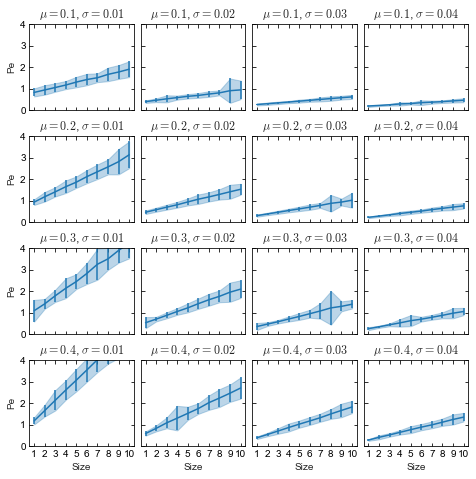

In [5]:
npar = 4
num_cells = 100
M = 10

fig, ax = plt.subplots(npar,npar,figsize=(6.5,6.5), sharey=True, sharex=True, constrained_layout=True)

x = np.arange(1,M+1)

kon = 1
kon1 = 0
mu = [0.1,0.2,0.3,0.4]
sigma = [0.01,0.02,0.03,0.04]
Pe_data = np.empty((npar,npar,10))

for k in range(npar):
    for l in range(npar):
        out = Parallel(n_jobs=-1, verbose=0)(delayed(mc)(i,mu[k],sigma[l],kon,kon1,M,1) for i in range(num_cells))
        pe, sp, velos, size, disp, state = zip(*out)
        
        Yavg = np.empty(10)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pe)[0]

        Y = np.array(pe)
        for j in range(10):
            Yavg[j] = np.mean(Y[:,:,j].ravel())
            Ystd[j] = np.std(Y[:,:,j].ravel())
    
        ax[k,l].fill_between(x = x,
                        y1 = Yavg - Ystd/np.sqrt(Ynum),
                        y2 = Yavg + Ystd/np.sqrt(Ynum),
                        alpha = 0.3,
                        color='C0')
        ax[k,l].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color='C0')
        ax[k,l].set_title('$\mu = {:.1f}$, $\sigma = {:.2f}$'.format(mu[k],sigma[l]))
        ax[k,l].set_xticks(np.arange(1,11))
        ax[k,l].set_ylim((0,4))
        
        Pe_data[k,l,:] = Yavg
        
for a in ax[:,0]:
    a.set_ylabel('Pe')
for a in ax[-1,:]:
    a.set_xlabel('Size')

fig.savefig('figures/Model1_ParamSweep.pdf',format='pdf')

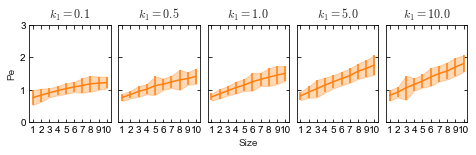

In [6]:
npar = 5

fig, ax = plt.subplots(1,npar,figsize=(6.5,2), sharey=True, sharex=True, constrained_layout=True)

kon = [0.1,0.5,1,5,10]
kon1 = 0
mu = 0.1
sigma = 0.01
Pe_data = np.empty((npar,10))

for k in range(npar):
    out = Parallel(n_jobs=-1, verbose=0)(delayed(mc)(i,mu,sigma,kon[k],kon1,M,2) for i in range(num_cells))
    pe, sp, velos, size, disp, state = zip(*out)

    Yavg = np.empty(10)
    Ystd = np.empty_like(Yavg)
    Ynum = np.shape(pe)[0]

    Y = np.array(pe)
    for j in range(10):
        Yavg[j] = np.mean(Y[:,:,j].ravel())
        Ystd[j] = np.std(Y[:,:,j].ravel())

    ax[k].fill_between(x = x,
                    y1 = Yavg - Ystd/np.sqrt(Ynum),
                    y2 = Yavg + Ystd/np.sqrt(Ynum),
                    alpha = 0.3,
                    color='C1')
    ax[k].errorbar(x = x,
                     y = Yavg,
                     yerr = Ystd/np.sqrt(Ynum),
                     color='C1')
    ax[k].set_title('$k_{1} =$'+'${:.1f}$'.format(kon[k]))
    ax[k].set_xticks(np.arange(1,11))
    ax[k].set_ylim((0,3))
    Pe_data[k,:] = Yavg
        
ax[0].set_ylabel('Pe')
ax[2].set_xlabel('Size')

fig.savefig('figures/Model2_ParamSweep.pdf',format='pdf')

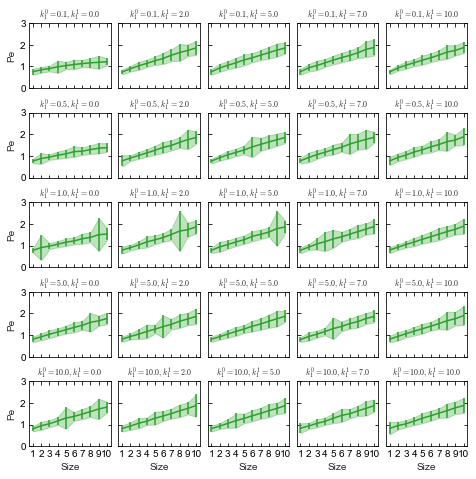

In [7]:
npar = 5

fig, ax = plt.subplots(npar,npar,figsize=(6.5,6.5), sharey=True, sharex=True, constrained_layout=True)

kon = [0.1,0.5,1,5,10]
kon1 = [0,2,5,7,10]
mu = 0.1
sigma = 0.01
Pe_data = np.empty((npar,npar,10))

for k in range(npar):
    for l in range(npar):
        out = Parallel(n_jobs=-1, verbose=0)(delayed(mc)(i,mu,sigma,kon[k],kon1[l],M,3) for i in range(num_cells))
        pe, sp, velos, size, disp, state = zip(*out)

        Yavg = np.empty(10)
        Ystd = np.empty_like(Yavg)
        Ynum = np.shape(pe)[0]

        Y = np.array(pe)
        for j in range(10):
            Yavg[j] = np.mean(Y[:,:,j].ravel())
            Ystd[j] = np.std(Y[:,:,j].ravel())

        ax[k,l].fill_between(x = x,
                        y1 = Yavg - Ystd/np.sqrt(Ynum),
                        y2 = Yavg + Ystd/np.sqrt(Ynum),
                        alpha = 0.3,
                        color='C2')
        ax[k,l].errorbar(x = x,
                         y = Yavg,
                         yerr = Ystd/np.sqrt(Ynum),
                         color='C2')
        ax[k,l].set_title('$k_{1}^0 =$'+'${:.1f},$'.format(kon[k])+'$ k_{1}^1 =$'+'${:.1f}$'.format(kon1[l]),fontsize=8)
        ax[k,l].set_xticks(np.arange(1,11))
        ax[k,l].set_ylim((0,3))
        Pe_data[k,l,:] = Yavg
        
for a in ax[:,0]:
    a.set_ylabel('Pe')
for a in ax[-1,:]:
    a.set_xlabel('Size')

fig.savefig('figures/Model3_ParamSweep.pdf',format='pdf')

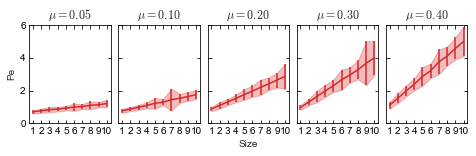

In [8]:
npar = 5

fig, ax = plt.subplots(1,npar,figsize=(6.5,2), sharey=True, sharex=True, constrained_layout=True)

kon = 0
kon1 = 0
mu = [0.05,0.1,0.2,0.3,0.4]
sigma = 0.01
Pe_data = np.empty((npar,10))

for k in range(npar):
    out = Parallel(n_jobs=-1, verbose=0)(delayed(mc)(i,mu[k],sigma,kon,kon1,M,4) for i in range(num_cells))
    pe, sp, velos, size, disp, state = zip(*out)

    Yavg = np.empty(10)
    Ystd = np.empty_like(Yavg)
    Ynum = np.shape(pe)[0]

    Y = np.array(pe)
    for j in range(10):
        Yavg[j] = np.mean(Y[:,:,j].ravel())
        Ystd[j] = np.std(Y[:,:,j].ravel())

    ax[k].fill_between(x = x,
                    y1 = Yavg - Ystd/np.sqrt(Ynum),
                    y2 = Yavg + Ystd/np.sqrt(Ynum),
                    alpha = 0.3,
                    color='C3')
    ax[k].errorbar(x = x,
                     y = Yavg,
                     yerr = Ystd/np.sqrt(Ynum),
                     color='C3')
    ax[k].set_title('$\mu =$'+'${:.2f}$'.format(mu[k]))
    ax[k].set_xticks(np.arange(1,11))
    ax[k].set_ylim((0,6))
    Pe_data[k,:] = Yavg
        
ax[0].set_ylabel('Pe')
ax[2].set_xlabel('Size')

fig.savefig('figures/Model4_ParamSweep.pdf',format='pdf')